This Python document replicates the graphs of the following paper: https://www.pnas.org/doi/epdf/10.1073/pnas.2114226119


The document collects the NFL stadium data, and applies Robust Synthetic control for all stadiums, to simulate
counterfactual outcomes of the hypothetical result that the stadiums didn't open, for experimental stadiums
 and placebo stadiums. 

This document also produces robustness check graphs on if the intervention week was 1-6 before the actual game date. 
as well as a IQR plot to demonstrate the ranges of results post game day. 


In [35]:
import numpy as np
import pandas as pd
import csv

import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
sys.path.append("../../..")
from sklearn.linear_model import Ridge
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso 
from sklearn.decomposition import PCA #USE PCA FOR PCR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import datetime
import math
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.neural_network import MLPRegressor

import warnings
from scipy.linalg import LinAlgWarning
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV


In [18]:
# Link for NFL Attendance Data: https://docs.google.com/spreadsheets/d/1DRMB5FLC3tdngeurDwps1CS8-6smEZvmq5R-ghjEv5k/edit#gid=0


#Import NFL Attendance Data using Pandas
attendance_df = pd.read_csv('NFL_Data.csv')

#Lots of NaN values, remove values without 'Team'
attendance_df = attendance_df.loc[~attendance_df['Team'].isnull()]

#Import NFL stadium County data, along with Neutral Counties
stadium_county_df = pd.read_csv('Stadium_County.csv',header=1) #Data is a little bit Messy 


#County Covid Rates Provided from NYTIMES Github Database, https://github.com/nytimes/covid-19-data/blob/master/us-counties-2020.csv
county_covid = pd.read_csv('County_Covid_Data.csv')

#Some data cleaning
stadium_county_df['Team '].fillna(method = 'ffill', inplace= True)
stadium_county_df.rename(columns={'Team ': 'Team'}, inplace=True)
county_covid['date'] = pd.to_datetime(county_covid['date'])
county_covid = county_covid.loc[~(county_covid['county'] == 'Unknown')]
county_covid = county_covid.loc[~(county_covid['cases'].isnull())]
county_covid['county'] = county_covid['county'].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Ignore LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [21]:
#We want to fill in state/county Data for cities that don't have stadium counties listed. Go through 1 by 1
no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']
stadium_county_df.loc[stadium_county_df['Team'] == 'Arizona', 'State'] = 'AZ'
stadium_county_df.loc[stadium_county_df['Team'] == 'Chicago', 'State'] = 'IL'
stadium_county_df.loc[stadium_county_df['Team'] == 'Detroit', 'State'] = 'MI'
stadium_county_df.loc[stadium_county_df['Team'] == 'Las Vegas', 'State'] = 'NV'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Chargers', 'State'] = 'CA'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Rams', 'State'] = 'CA'
stadium_county_df.loc[stadium_county_df['Team'] == 'Minnesota', 'State'] = 'MN'
stadium_county_df.loc[stadium_county_df['Team'] == 'New England', 'State'] = 'MA'
stadium_county_df.loc[stadium_county_df['Team'] == 'New Orleans', 'State'] = 'LA'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Giants', 'State'] = 'NJ'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Jets', 'State'] = 'NJ'
stadium_county_df.loc[stadium_county_df['Team'] == 'San Francisco', 'State'] = 'CA'
stadium_county_df.loc[stadium_county_df['Team'] == 'Seattle', 'State'] = 'WA'
stadium_county_df.loc[stadium_county_df['Team'] == 'Washington', 'State'] = 'District of Columbia'
stadium_county_df.loc[stadium_county_df['Team'] == 'Arizona', 'County(s)'] = 'Maricopa'
stadium_county_df.loc[stadium_county_df['Team'] == 'Chicago', 'County(s)'] = 'Cook'
stadium_county_df.loc[stadium_county_df['Team'] == 'Detroit', 'County(s)'] = 'Wayne'
stadium_county_df.loc[stadium_county_df['Team'] == 'Las Vegas', 'County(s)'] = 'Clark'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Chargers', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Rams', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team'] == 'Minnesota', 'County(s)'] = 'Ramsey'
stadium_county_df.loc[stadium_county_df['Team'] == 'New England', 'County(s)'] = 'Norfolk'
stadium_county_df.loc[stadium_county_df['Team'] == 'New Orleans', 'County(s)'] = 'Orleans'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Giants', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Jets', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team'] == 'San Francisco', 'County(s)'] = 'Santa Clara'
stadium_county_df.loc[stadium_county_df['Team'] == 'Seattle', 'County(s)'] = 'King'
stadium_county_df.loc[stadium_county_df['Team'] == 'Washington', 'County(s)'] = 'District of Columbia'
stadium_county_df['County(s)'] = stadium_county_df['County(s)'].apply(lambda x: x.lower() if isinstance(x, str) else x)
stadium_county_df['Counties'] = stadium_county_df['Counties'].apply(lambda x: x.lower() if isinstance(x, str) else x)


#Dictionary to convert state acronyms to state names, used for data processing. 
home_state_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


We want to associate NFL teams to their respective Counties. Add Column that contains 'HOME COUNTIES', and columns that contains 'NEUTRAL COUNTIES'

This allows us to differentiate between synthetic counties and donor counties for our synthetic control later. 


In [31]:
def find_stadium_counties(team_city_str):
    team_city_data = stadium_county_df.loc[stadium_county_df['Team'] == team_city_str]
    #team_city_data = team_city_data[team_city_data['County(s)'].notnull()]
    
    #Take away counties that don't belong in home state
    home_state = list(team_city_data['State'])[0]
    team_city_data = team_city_data[team_city_data['State.1'] == home_state]
    
    if team_city_str in no_fans_list:
        #If no fans, there actually is NO stadium county, since they are *not* affected by opening stadium. 
        return ""
    
    return list(set(team_city_data['County(s)']))

def find_donor_counties(team_city_str): #All counties within the state that is NOT in buffer counties.
    team_city_data = stadium_county_df.loc[stadium_county_df['Team'] == team_city_str]
    team_city_data = team_city_data[team_city_data['Counties'].notnull()]
    
    #Take away counties that don't belong in home state
    if(len(list(team_city_data['State'])) > 0): #If a home state exists... some not included in data set
        home_state = list(team_city_data['State'])[0]
    else: #Exceptions
        if team_city_str == 'Arizona':
            home_state = "AZ"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'Detroit':
            home_state = "MI"
        elif team_city_str == 'Las Vegas':
            home_state = "NV"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'LA Chargers':
            home_state = "CA"
        elif team_city_str == 'Kansas Chity':
            home_state = "MO"
        elif team_city_str == 'LA Rams':
            home_state = "CA"
        elif team_city_str == 'Minnesota':
            home_state = "MN"
        elif team_city_str == 'New England':
            home_state = "MA"
        elif team_city_str == 'New Orleans':
            home_state = "LA"
        elif team_city_str == 'NY Giants':
            home_state = "NJ"
        elif team_city_str == 'NY Jets':
            home_state = "NJ"
        elif team_city_str == 'San Francisco':
            home_state = "CA"
        elif team_city_str == 'Seattle':
            home_state = "WA"
        elif team_city_str == 'Washington':
            home_state = "MD"
        else:
            print(team_city_str)
            home_state = ''
            
    #Home State dictionary from 2 Letters to Full Name

    buffer_counties = list(set(stadium_county_df.loc[(stadium_county_df['State.1'] == home_state)]['Counties'])) #List of neutral counties IN HOME STATE
    
    stadium_counties = list(set(stadium_county_df.loc[(stadium_county_df['State'] == home_state)]['County(s)'])) #List of Stadium counties
    
    #Run through home_state_dict, as county_covid dataset uses full names for states rather than abbreviations

    home_state = home_state_dict[home_state]
    
    donor_counties = county_covid.loc[(county_covid['state'] == home_state)] #All county covid for home state

    donor_counties = donor_counties.loc[~donor_counties['county'].isin(buffer_counties) & (~donor_counties['county'].isin(stadium_counties))]

    donor_counties = donor_counties.loc[donor_counties['cases'] > 200]

    donor_counties = list(set(donor_counties['county']))
    
    return donor_counties

stadium_county_df['Stadium_Counties'] = stadium_county_df['Team'].apply(find_stadium_counties)
stadium_county_df['Donor_Counties'] = stadium_county_df['Team'].apply(find_donor_counties)
    
    
stadium_county_df['Stadium_Counties'] = stadium_county_df['Stadium_Counties'].apply(lambda x: [s.lower() if isinstance(s, str) else s for s in x])
stadium_county_df['Donor_Counties'] = stadium_county_df['Donor_Counties'].apply(lambda x: [s.lower() if isinstance(s, str) else s for s in x])

no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']


###
stadium_county_df.to_csv('Cleaned_stadium_data.csv')
###

Next, we define our synthetic control graph generation process, where we apply a PCA approach, by performing a
singular value decomposition, and choose the minimum amount of singular values that allow our regression to have a norm value of case difference to be less than 1%. 

In the case where no singular value passes the 1% check, we repeat the process with 1.5% and 2% subsequently. (Appendix)

After such a value is chosen, we then use the regression weights on the post intervention data to construct 
the synthetic counterfactual results. 



(Appendix): We observe that for San Francisco and Dallas, our chosen singular value has a meaningful difference than the original paper through the process. We note the difference and also use their values to show the results. 

In [24]:
#Make earlier process into a function to generalize to other Stadiums

Total_prediction_data_fans = []
Total_prediction_data_no_fans = []

def create_synthetic_graph(team_name_str, stadium_county_str, state_str, intervention_date, show_plot, week):
    
    stadium_county_str = [x for x in stadium_county_str if x != ""]
    state_str = [x for x in state_str if x != ""]
    intervention_date = [x for x in intervention_date if x != ""]
    
    #Convert to lower case to avoid case insensitivity later
    stadium_county_str = [s.lower() for s in stadium_county_str]
    #To find intervention_date, we want first entry that has numbers, since some in data is text only.
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s

    intervention_date = pd.to_datetime(intervention_date)
    

    #Convert State Acronym to full state name
    for state in range(len(state_str)):
        if state_str[state] in home_state_dict:
            state_str[state] = home_state_dict[state_str[state]]
            
    #Find Synthetic Counties
    synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == team_name_str]['Donor_Counties'])[0].copy()
    synthetic_counties = [s.lower() for s in synthetic_counties]
    n_donors = len(synthetic_counties)

    #Find Dataframe of X and Y data
    #Special case where 
    if team_name_str == 'Washington':
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str)) | ((county_covid['county'].isin(synthetic_counties)) & (county_covid['state'] == 'Maryland'))]
    else:
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str) | (county_covid['county'].isin(synthetic_counties))) & (county_covid['state'].isin(state_str))]
    
    stadium_county_data = stadium_county_data.fillna(method='bfill')
    stadium_county_data['date'] = pd.to_datetime(stadium_county_data['date'], infer_datetime_format=True)
    
    earliest_date = list(stadium_county_data.loc[stadium_county_data['county'].isin(stadium_county_str)]['date'])[0]
    
    #Start training from the earliest date of when our stadium county data becomes available.
    stadium_county_data = stadium_county_data.loc[stadium_county_data['date'] >= earliest_date]
    
    #CONVERT ALL OF THIS INTO A PIVOT TABLE FIRST
    
    ########
    
    
    #Total Pivot is pivot table cases for entire dataset, training pivot is the same but for < intervention date
    total_pivot = stadium_county_data.pivot_table(columns='county', values='cases', index= 'date').reset_index()
    total_pivot = total_pivot.loc[total_pivot['date'] >= earliest_date]
    
    #Sum up stadium counties for our prediction. 
    total_pivot['Stadium_County'] = total_pivot.apply(lambda row: row[stadium_county_str].sum(), axis=1)
    #total_pivot['Stadium_County'] = total_pivot.loc[:, total_pivot.columns == (stadium_county_str[0])]
    
    total_pivot.drop(stadium_county_str, axis=1, inplace=True)
    
    total_pivot.fillna(0, inplace=True)
    
    training_pivot = total_pivot.loc[total_pivot['date'] < intervention_date]
    
    training_dates = training_pivot['date']
    
    total_dates = total_pivot['date']
    
    training_pivot = training_pivot.drop(['date'], axis=1)
    
    total_pivot = total_pivot.drop(['date'], axis=1)
    
    X_train = training_pivot.loc[:, ~training_pivot.columns.isin(['Stadium_County'])]
    
    Y_train = training_pivot['Stadium_County']
    
    num_pre_dates = X_train.shape[0]
    
    
    #Keep total X and Y data for future plots
    total_X = total_pivot.loc[:, ~total_pivot.columns.isin(['Stadium_County'])]
    total_Y = total_pivot['Stadium_County']
    
    assert total_X.shape[0] == total_Y.shape[0]
    
    
    ###########
    
    U, S, V = np.linalg.svd(X_train, full_matrices=False)

    total_columns = X_train.columns
    stadium_key = 'Stadium_County'
    donor_key = total_columns
    
    aggregate_errors = []
    r_squareds = []
    
    for svalue in range(1,len(S)+1):
        
        singvals = svalue
        rscModel = RobustSyntheticControl(stadium_key, singvals, len(training_pivot), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=donor_key)
        rscModel.fit(training_pivot)
        
        denoisedDF = rscModel.model.denoisedDF()

        predictions = []
        predictions = np.dot(X_train, rscModel.model.weights) #Prediction fits pre-intervention
        #predictions = predictions.astype(int)
        
        assert predictions.shape[0] == num_pre_dates
        
        aggregate_y = Y_train # Actual Y cases 

        assert len(aggregate_y) == len(predictions)
        
        
        aggregate_error = np.linalg.norm(aggregate_y - predictions) / np.linalg.norm(aggregate_y)

        aggregate_errors.append(aggregate_error)
    

        if (aggregate_error < 0.01):
            
            print(svalue)
            break
            
            
        if svalue == (len(S)):
            print("Uses all singular values initially")
            
            if min(aggregate_errors) < 0.015:
                svalue = aggregate_errors.index(list(filter(lambda k: k < 0.015, aggregate_errors))[0]) + 1
                
            elif min(aggregate_errors) < 0.02:
                svalue = aggregate_errors.index(list(filter(lambda k: k < 0.02, aggregate_errors))[0]) + 1
            else:
                svalue = len(S)
            print("Our final Kept singular value")
            print(svalue)
            break
        
        
    if team_name_str == 'San Francisco':
        svalue = 9
    elif team_name_str == 'Dallas':
        svalue = 31
        
        
    total_columns = total_X.columns
    stadium_key = 'Stadium_County'
    donor_key = total_columns



    rscModel = RobustSyntheticControl(stadium_key, svalue, len(training_pivot), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=donor_key)
    rscModel.fit(training_pivot)
    denoisedDF = rscModel.model.denoisedDF()
    
    predictions = []
    predictions = np.dot(total_X, rscModel.model.weights)

    #Following adds prediction data to construct historgram results T+days after intervention date
    if team_name_str in no_fans_list:
        Total_prediction_data_no_fans.append((-predictions[num_pre_dates:num_pre_dates + 21] +
                                     list(total_Y)[num_pre_dates:num_pre_dates + 21])/
                                             predictions[num_pre_dates:num_pre_dates + 21])
    else:
        Total_prediction_data_fans.append((-predictions[num_pre_dates:num_pre_dates + 21] +
                                     list(total_Y)[num_pre_dates:num_pre_dates + 21])/
                                          predictions[num_pre_dates:num_pre_dates + 21])
    
    assert predictions.shape[0] == total_Y.shape[0]
    
    if show_plot == True:

        #Plot Hamilton_synthetic along with actual Hamilton data past 10/4 results. 
        fig, ax = plt.subplots()

        plt.plot(total_dates, total_Y, label = stadium_county_str)
        plt.plot(total_dates, predictions, label='Synthetic RBSC')
        
        plt.xticks(rotation=45)
        plt.title(team_name_str + " " + stadium_county_str[0] + " County Covid Cases ")

        plt.tick_params(axis='x', which='major')
        plt.axvline(x=intervention_date, ymin = 0, ymax = 1, color='grey')
        fig.autofmt_xdate()

        ax.legend()
        ax.xaxis_date()
        plt.show()
    else: #Below is for Synthetic Lines, which plots all six weeks onto the same plot. 
        true_intervention = intervention_date + datetime.timedelta(weeks=week)
        
        if week == -1: #Just return predictions, no plot. Used for RBSC when comparing with Bayesian Models
            return predictions
        elif week == 0:
            plt.plot(total_dates, predictions, label='Synthetic Week Before', color = 'blue')
        else:
            plt.plot(total_dates, predictions, label='Synthetic Week Before', color = 'grey')

        plt.xticks(rotation=45)
        plt.title(team_name_str + " " + stadium_county_str[0] + " County Covid Cases ")
        
        plt.tick_params(axis='x', which='major')
        plt.axvline(x=true_intervention, ymin = 0, ymax = 1, color='grey')

    return predictions

The following function repeats the above function but for all 6 potential weeks near the intervention date to check 
the robustness of the method, and graphs them all together in one plot. 

In [25]:
def create_synthetic_lines(team_name_str, stadium_county_str, state_str, intervention_date):
    intervention_date = [x for x in intervention_date if x != ""]
    
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s
            
    intervention_date = pd.to_datetime(intervention_date)
    intervention_array = [intervention_date - datetime.timedelta(weeks=i) for i in range(0, 7)]
    print(team_name_str)
    count = 0
    for intervention in intervention_array: 
        
        intervention = intervention.strftime('%m/%d/%Y')
        l = []
        l.append(intervention)
        l.append("")
        
        create_synthetic_graph(team_name_str, stadium_county_str, state_str, l, False, count)
        
        count += 1
    plt.show()
    
    return 


In [33]:
grouped_df

,Team,First date home stadium open to fans,County(s),State
0,Arizona,[10/25/2020],[maricopa],[AZ]
1,Atlanta,"[10/25/2020, , , , , , , , , ]","[fulton, , , , , , , , , ]","[GA, , , , , , , , , ]"
2,Baltimore,"[11/1/2020, , , , , , , ]","[baltimore, baltimore city, , , , , , ]","[MD, MD, , , , , , ]"
3,Buffalo,"[Post season fans, First home, game no fans:, ...","[erie, , , , ]","[NY, , , , ]"
4,Carolina,"[10/4/2020, , , , , , , , ]","[mecklenburg, , , , , , , , ]","[NC, , , , , , , , ]"
5,Chicago,[9/20/2020],[cook],[IL]
6,Cincinnati,"[10/4/2020, , , , , , , , , , ]","[hamilton, , , , , , , , , , ]","[OH, , , , , , , , , , ]"
7,Cleveland,"[9/17/2020, , , , , , , , , ]","[cuyahoga, , , , , , , , , ]","[OH, , , , , , , , , ]"
8,Dallas,"[9/20/2020, , , , , , , , , ]","[dallas, tarrant, , , , , , , , ]","[TX, TX, , , , , , , , ]"
9,Denver,"[9/27/2020, , , , , , , , , , ]","[denver, arapahoe, , , , , , , , , ]","[CO, CO, , , , , , , , , ]"


Below we iterate through the different stadiums to plot the graphs for each stadium county, as well as 
plot the robustness check for the 1-6 week prior to intervention

7


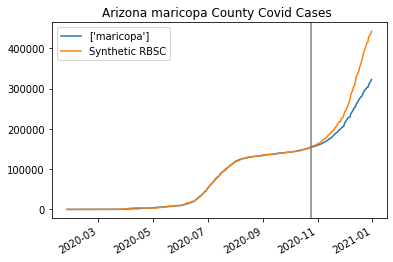

5


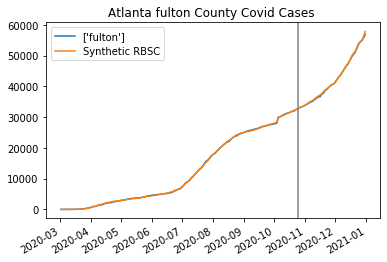

5


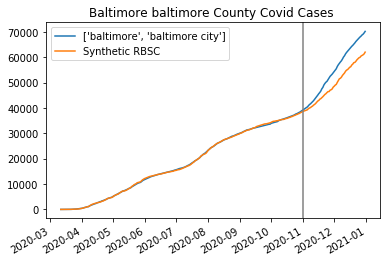

10


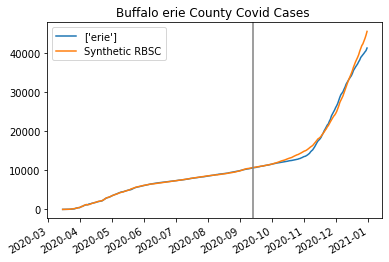

4


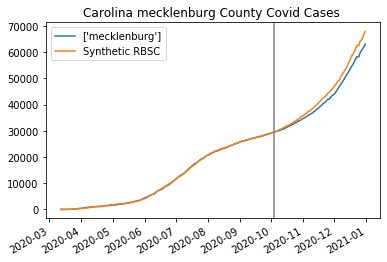

3


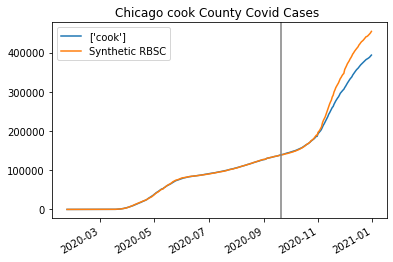

12


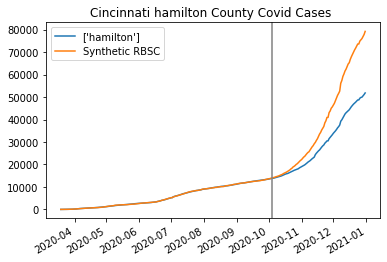

15


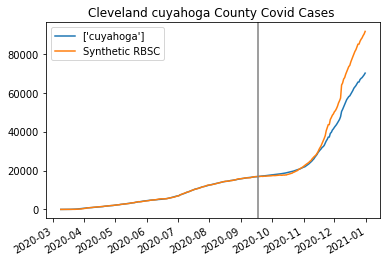

37


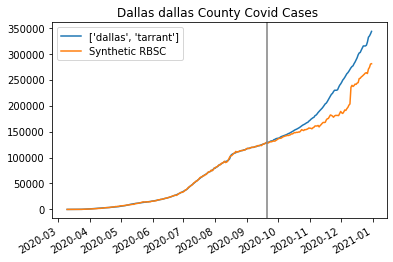

6


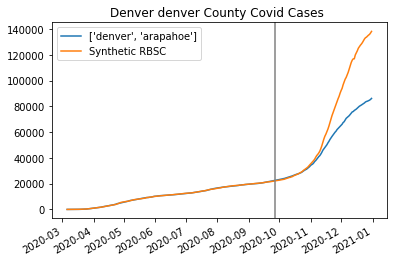

14


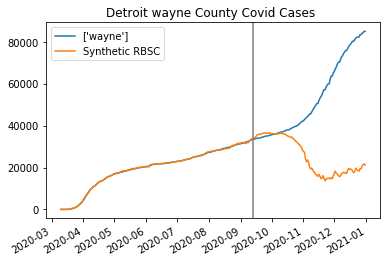

Uses all singular values initially
Our final Kept singular value
14


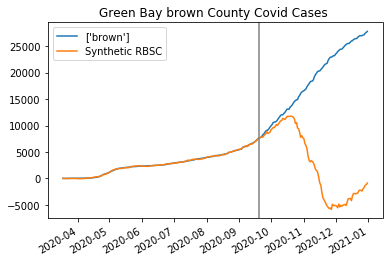

13


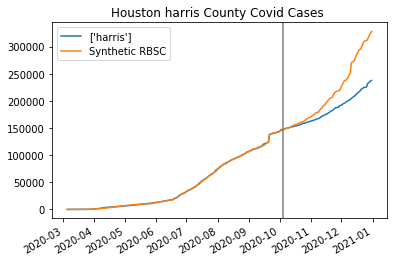

9


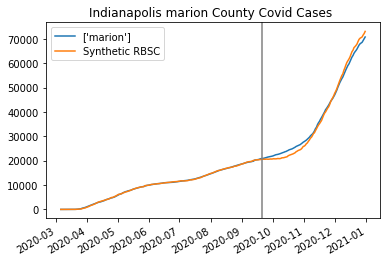

9


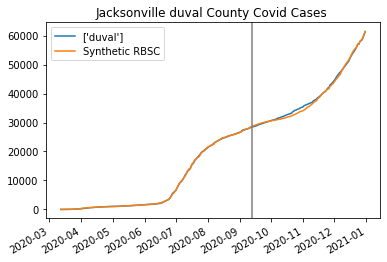

10


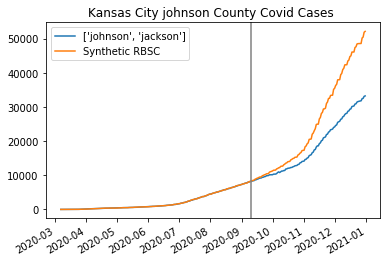

6


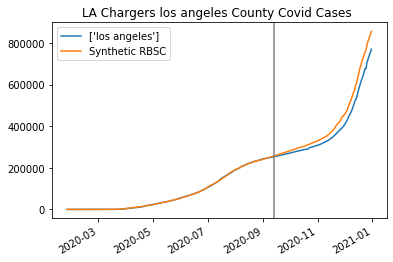

6


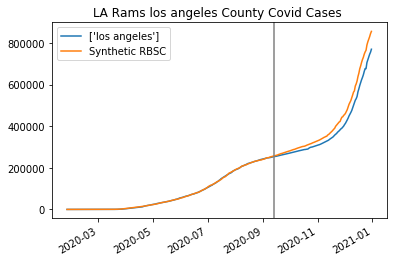

Uses all singular values initially
Our final Kept singular value
4


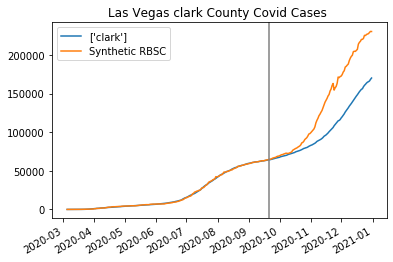

7


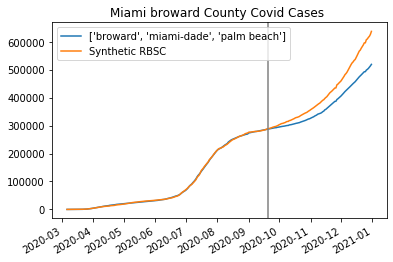

6


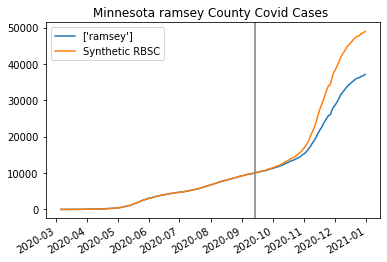

3


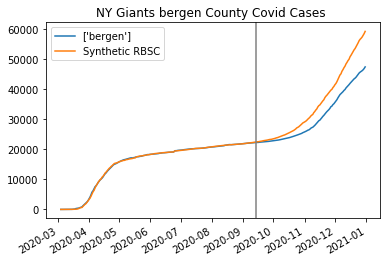

3


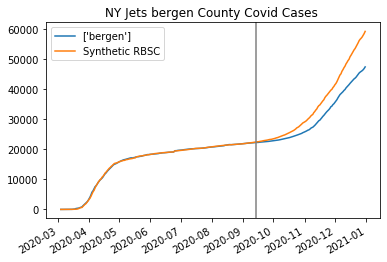

7


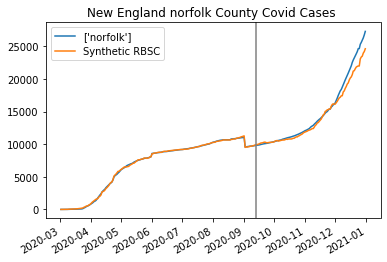

Uses all singular values initially
Our final Kept singular value
10


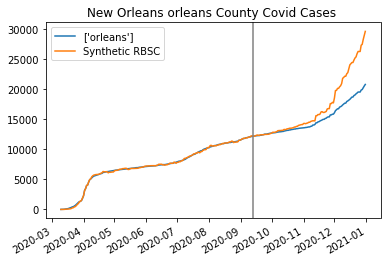

8


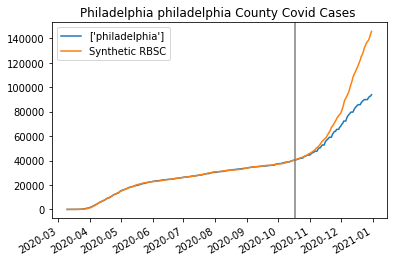

22


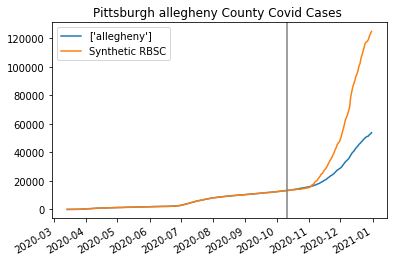

Uses all singular values initially
Our final Kept singular value
12


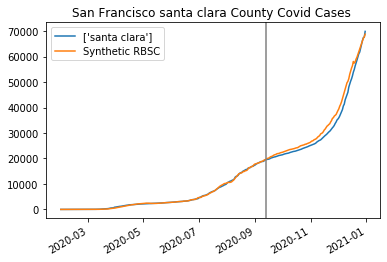

Uses all singular values initially
Our final Kept singular value
5


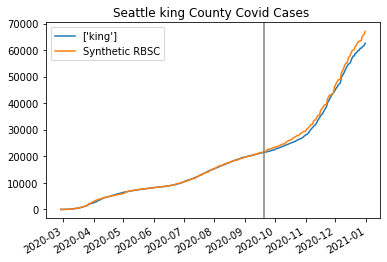

8


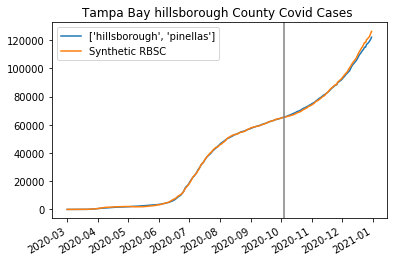

14


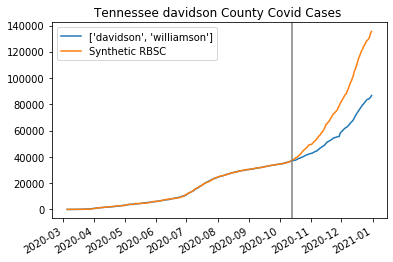

Uses all singular values initially
Our final Kept singular value
5


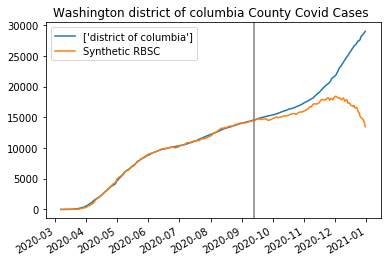

In [38]:
#Compute graphs for all combinations 

dropped_stadium_df = stadium_county_df[['Team', 'First date home stadium open to fans','County(s)', 'State']]
dropped_stadium_df = dropped_stadium_df.fillna("")
grouped_df = dropped_stadium_df.groupby('Team').agg(list)
grouped_df.reset_index(inplace=True)

#We want to manually fill in Dates for stadiums not open to fans, due to inconsistency in data source. 
grouped_df.loc[grouped_df['Team'] == 'Chicago', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Detroit', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Las Vegas', 'First date home stadium open to fans'] = [['9/21/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Chargers', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Rams', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Minnesota', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New England', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New Orleans', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Giants', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Jets', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'San Francisco', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Seattle', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Tennessee', 'First date home stadium open to fans'] = [['10/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Washington', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Pittsburgh', 'First date home stadium open to fans'] = [['10/11/2020']]
grouped_df.loc[grouped_df['Team'] == 'Kansas City', 'First date home stadium open to fans'] = [['9/10/2020']] #Error in data set

#dropped_stadium_df = dropped_stadium_df.drop_duplicates(subset='Team') #Only need 1 for each team
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

grouped_df.to_csv('Grouped_df.csv')
for i, (team, county, state, date) in enumerate(zipped_input):
    synthetic_control = create_synthetic_graph(team, county, state, date, True, 0)
    
    
    #After obtaining the synthetic_control, we store the result file for our comparison to our Poisson Bayesian Model. 
    
    np.save(f'RBSC_Replications/{team}_RBSC.npy', synthetic_control)

    

        

Additionally, we also plot results for post game day deviations, the IQR ranges. 

In [16]:
#Create graphs for results after Game day. 

assert np.array(Total_prediction_data_no_fans).shape == (14, 21) #NUmber of teams, number of days past intervention
assert np.array(Total_prediction_data_fans).shape == (17, 21)

IQR_list = []

Time_series_no_fans = np.array(Total_prediction_data_no_fans).T #Transpose of time series data
Time_series_fans = np.array(Total_prediction_data_fans).T

# q1, q3 = np.percentile(Time_series, [25, 75], axis=1)
# iqr = q3 - q1

# print(q1)
# print(q3)

#plt.fill_betweenx(np.arange(len(iqr)), q1, q3, color='b', alpha=0.2)
fig, ax = plt.subplots()

plt.boxplot(Time_series_no_fans.T, vert=True, showfliers = False)
ax.set_ylim(bottom=-0.3,top = 0.3)
plt.xlabel("Days after Intervention")
plt.ylabel("Relative Difference Delta")
plt.title("Days after Intervention Delta for Stadium with No Fans")
ax.axhline(0, color='grey', linestyle='--')

# Show the plot
plt.show()

fig,ax = plt.subplots()

plt.boxplot(Time_series_fans.T, vert=True, showfliers = False)
ax.set_ylim(bottom=-0.3,top=0.3)

plt.xlabel("Days after Intervention")
plt.ylabel("Relative Difference Delta")
plt.title("Days after Intervention Delta for Stadium with Fans")
ax.axhline(0, color='grey', linestyle='--')
plt.show()
    

AssertionError: 